In [1]:
##################################################################################################################
# IMPORT MODULES
##################################################################################################################

import matplotlib as mpl
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import glob

from pyhdf.SD import SD, SDC, SDAttr, HDF4Error
from pyhdf import HDF, VS, V
from pyhdf.HDF import *
from pyhdf.VS import *

import pprint
#from pyproj import Proj, transform

import os
import os.path
import sys 

import matplotlib as mpl
import cartopy.crs as ccrs
#import pyresample

import datetime

label_size=12
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

['2007001104500_03613_CS_ECMWF-AUX_GRANULE_P_R05_E02_F00.hdf']


/Users/timcar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


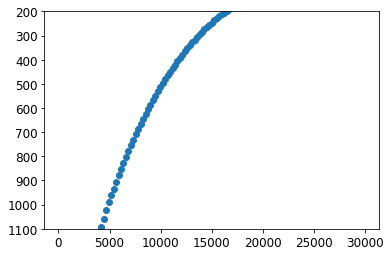

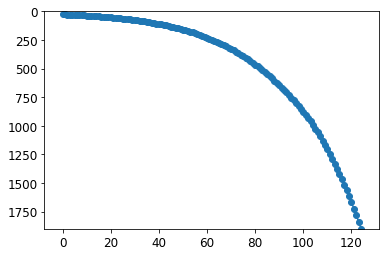

In [10]:
##################################################################################################################
# GENERATE PRESSURE GRID from mean pressure profile Southern Ocean
##################################################################################################################
from scipy.optimize import curve_fit

def exponential_fit(x, a, b, c):
    return a*np.exp(b*x) + c


year = 2007
granule = 3613
file_aux = glob.glob('*'+str(granule)+'*ECMWF-AUX*.hdf')
print(file_aux)

# Check if file exists
if file_aux:
    file_aux = file_aux[0]
else:
    print('Cannot generate pressure grid (file missing)...')
    sys.exit()

try:
    hdf_aux = SD(file_aux, SDC.READ)

    sds_obj = hdf_aux.select('Pressure') # select sds
    pres = sds_obj.get() # get sds data
    pres = pres / 100. # in hPa

    
    f = HDF(file_aux) 
    vs = f.vstart() 
    Latitude = vs.attach('Latitude')
    Longitude = vs.attach('Longitude')
    lat = np.array(Latitude[:])
    lon = np.array(Longitude[:])
    Latitude.detach() # "close" the vdata
    Longitude.detach() # "close" the vdata
    vs.end() # terminate the vdata interface
    f.close()
    
except HDF4Error as msg:
    print("HDF4Error ECMWF-AUX", msg)
    print("Cannot generate pressure grid (reading error) ...")
    sys.exit()
    

# Define Southern Ocean
index_so=np.where((lat.flatten() < -40) & (lat.flatten() > -70))
index_so=np.array(index_so)
index_so=index_so.flatten()


# Generate linear height grid
h = 120.
for i in range(124):
    h=np.append(h,np.max(h)+240.)
h = h[::-1]

# Generate exponential pressure grid from mean over SO of one exemplary granule
pres[np.where(pres == -9.99)] = np.nan
pres_mean = np.nanmean(pres[index_so,:], axis=0)


dummy = np.array(pres_mean[np.where(np.isfinite(pres_mean))])

x = np.arange(dummy.size)
y = dummy.flatten()

fitting_parameters, covariance = curve_fit(exponential_fit, x, y, p0=[1, -1, 0])
a, b, c = fitting_parameters

next_x = np.arange(len(h[dummy.size:125]))+dummy.size
next_y = exponential_fit(next_x, a, b, c)

#next_y corrected by 15hPa to fit to existing curve (roughly determined via including last point in exponential_fit)
next_y = next_y - 15.

pres_grid = np.append(dummy, next_y)   
n_pres = len(pres_grid)

plt.scatter(h,pres_grid)
plt.ylim(1100,200)
plt.show()

plt.plot(pres_grid)
plt.scatter(np.arange(125),pres_grid)
plt.ylim(1900,0)
plt.show()

outfile = 'pres_grid_SO.dat'
np.savetxt(outfile, list(pres_grid),delimiter='   ',fmt='%11.12f')


In [11]:
print(pres_grid)

[  25.80005455   26.77323723   27.746315     28.71940804   29.69555283
   30.85063171   32.06476212   33.27961349   34.49384308   35.70843506
   36.91784286   38.21681595   39.74407959   41.27172852   42.7985611
   44.32645798   45.8476181    47.51812363   49.39730453   51.27867508
   53.16002655   55.04144669   57.01653671   59.27810287   61.60247421
   63.92686081   66.25115204   68.57556152   71.04392242   73.79294586
   76.65486908   79.51682281   82.37882996   85.35420227   88.52363586
   91.89575958   95.28876495   98.8385849   102.58013153  106.53373718
  110.49306488  114.51815033  118.75922394  123.21208191  127.89511108
  132.59512329  137.44200134  142.49269104  147.79646301  153.27070618
  158.95489502  164.80267334  170.91416931  177.25505066  183.80792236
  190.61116028  197.68930054  205.03225708  212.61071777  220.53791809
  228.79301453  237.31736755  246.1315155   255.28953552  264.83731079
  274.60089111  284.79379272  295.33694458  306.07299805  317.25033569
  328.8

In [12]:
test_grid = np.loadtxt(outfile)

In [14]:
print(test_grid)

[  25.80005455   26.77323723   27.746315     28.71940804   29.69555283
   30.85063171   32.06476212   33.27961349   34.49384308   35.70843506
   36.91784286   38.21681595   39.74407959   41.27172852   42.7985611
   44.32645798   45.8476181    47.51812363   49.39730453   51.27867508
   53.16002655   55.04144669   57.01653671   59.27810287   61.60247421
   63.92686081   66.25115204   68.57556152   71.04392242   73.79294586
   76.65486908   79.51682281   82.37882996   85.35420227   88.52363586
   91.89575958   95.28876495   98.8385849   102.58013153  106.53373718
  110.49306488  114.51815033  118.75922394  123.21208191  127.89511108
  132.59512329  137.44200134  142.49269104  147.79646301  153.27070618
  158.95489502  164.80267334  170.91416931  177.25505066  183.80792236
  190.61116028  197.68930054  205.03225708  212.61071777  220.53791809
  228.79301453  237.31736755  246.1315155   255.28953552  264.83731079
  274.60089111  284.79379272  295.33694458  306.07299805  317.25033569
  328.8

In [15]:
print(test_grid - pres_grid)

[ 1.03028697e-13  4.44089210e-13 -4.05009359e-13 -3.19744231e-13
  2.66453526e-13 -1.88293825e-13  4.83169060e-13 -4.97379915e-14
 -2.84217094e-13  2.48689958e-13 -2.34479103e-13 -3.26849658e-13
  2.48689958e-13  0.00000000e+00 -4.05009359e-13  7.81597009e-14
 -3.41060513e-13  1.42108547e-14 -1.06581410e-13  2.98427949e-13
  2.84217094e-14 -1.42108547e-14 -4.83169060e-13  1.42108547e-13
 -4.83169060e-13 -1.70530257e-13 -2.13162821e-13  4.97379915e-13
 -4.12114787e-13 -4.12114787e-13  1.56319402e-13 -4.12114787e-13
  3.12638804e-13  1.84741111e-13  1.84741111e-13  4.68958206e-13
 -2.84217094e-13 -3.41060513e-13  2.84217094e-13 -1.84741111e-13
 -9.94759830e-14  1.56319402e-13 -2.84217094e-13  3.12638804e-13
 -3.69482223e-13  3.69482223e-13 -4.26325641e-13 -5.68434189e-14
 -3.12638804e-13  1.98951966e-13 -2.55795385e-13  2.55795385e-13
 -4.26325641e-13  3.12638804e-13 -2.55795385e-13 -3.12638804e-13
 -3.69482223e-13 -1.13686838e-13  5.11590770e-13 -3.12638804e-13
 -1.98951966e-13  5.68434